### 75 / 25

In [93]:
# a class imbalance of 75 / 25 means that 
# 5.000.000*0.75 = 3.750.000 of the 5.000.000 samples are of class 0
# 5.000.000*0.25 = 1.250.000 of the 5.000.000 samples are of class 1


In [94]:
pip install imbalanced-learn scikit-learn

In [95]:
pip show scikit-learn

Name: scikit-learn
Version: 1.5.2
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

Copyright (c) 2007-2024 The scikit-learn developers.
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS 

In [96]:
pip show imbalanced-learn

Name: imbalanced-learn
Version: 0.12.4
Summary: Toolbox for imbalanced dataset in machine learning.
Home-page: https://github.com/scikit-learn-contrib/imbalanced-learn
Author: 
Author-email: 
License: MIT
Location: c:\Anaconda\Lib\site-packages
Requires: joblib, numpy, scikit-learn, scipy, threadpoolctl
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [97]:
pip install -U scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.model_selection import train_test_split
import numpy as np


In [99]:
# Need to oversample the minority class of 1, as the data available only has 293568 rows, and I need 1.250.000 rows

In [2]:
dtype = {
    'ResponseID': 'category',
    'UserID': 'int8',
    'Intervention': 'int8',
    'PedPed': 'int8',
    'Barrier': 'int8',
    'CrossingSignal': 'int8',
    'AttributeLevel': 'category',
    'ScenarioTypeStrict': 'category',
    'NumberOfCharacters': 'int8',
    'DiffNumberOFCharacters': 'int8',
    'Saved': 'int8',
    'Man': 'int8',
    'Woman': 'int8',
    'Pregnant': 'int8',
    'Stroller': 'int8',
    'OldMan': 'int8',
    'OldWoman': 'int8',
    'Boy': 'int8',
    'Girl': 'int8',
    'Homeless': 'int8',
    'LargeWoman': 'int8',
    'LargeMan': 'int8',
    'Criminal': 'int8',
    'MaleExecutive': 'int8',
    'FemaleExecutive': 'int8',
    'FemaleAthlete': 'int8',
    'MaleAthlete': 'int8',
    'FemaleDoctor': 'int8',
    'MaleDoctor': 'int8',
    'Dog': 'int8',
    'Cat': 'int8'
}


In [101]:
df_total = pd.read_csv('sub_10000.csv', dtype=dtype)

In [102]:
df_total.shape

(10000, 31)

## Hier encode je en haal je responseID weg voordat je gaat oversamplen, waarom????

In [103]:
df_total = pd.get_dummies(df_total, columns=['AttributeLevel', 'ScenarioTypeStrict'])

In [104]:
X = df_total.drop(['UserID', 'ResponseID'], axis=1)
y = df_total['UserID']

In [116]:
X.shape

(10000, 46)

In [117]:
y.value_counts()

UserID
0    9800
1     200
Name: count, dtype: int64

In [136]:
from imblearn.over_sampling import SMOTE

# Set k_neighbors to a lower value (default is 5)
# smote = SMOTE(sampling_strategy=0.2, k_neighbors=2, random_state=42)

In [155]:
# Step 2: Apply SMOTE and Random Oversampling
# smote = SMOTE(sampling_strategy=0.5, random_state=42)
sampling_strategy = {0: 9800, 1: 835}
random_oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

In [156]:
# Apply SMOTE first
X_random, y_random = random_oversampler.fit_resample(X, y)

In [157]:
y_random.value_counts()

UserID
0    9800
1     835
Name: count, dtype: int64

In [32]:
# X_balanced, y_balanced = random_oversampler.fit_resample(X_smote, y_smote)

In [33]:
y_balanced.value_counts()

UserID
0    9800
1    9800
Name: count, dtype: int64

In [34]:
X_balanced.shape

# totale dataset heeft nu dan 20.000

# increased llm's from 200 --> 9800 (increase of 4800% increase)

# need increase of 316% in the 75/25 dataset
# 733% increase in the 50/50 dataset

(19600, 46)

In [145]:
Xy_random = pd.concat([X_random, y_random], axis=1)
# Xy_balanced = pd.concat([X_balanced, y_balanced], axis=1)

In [146]:
df_total[df_total['UserID'] == 1].describe()

,UserID,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,...,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,200.0,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.00000,...,200.000000,200.000000,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,1.0,0.500000,0.500000,0.250000,0.550000,3.065000,0.290000,0.500000,0.375000,0.29000,...,0.160000,0.075000,0.135000,0.080000,0.13000,0.155000,0.110000,0.100000,0.195000,0.170000
std,0.0,0.501255,0.501255,0.434099,0.774921,1.487224,0.740705,0.501255,0.588307,0.56346,...,0.453241,0.299707,0.421501,0.322677,0.40487,0.438103,0.372281,0.347279,0.639547,0.585503
min,1.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.500000,0.500000,0.000000,0.000000,3.000000,0.000000,0.500000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,1.000000,1.000000,0.250000,1.000000,5.000000,0.000000,1.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.000000,1.000000,1.000000,2.000000,5.000000,4.000000,1.000000,3.000000,3.00000,...,2.000000,2.000000,3.000000,3.000000,2.00000,2.000000,2.000000,2.000000,4.000000,3.000000


In [147]:
Xy_random[Xy_random['UserID'] == 1].describe()

# dit is smote dus synthetic data created

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,...,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,UserID
count,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,...,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.000000,1960.0
mean,0.492347,0.519898,0.244898,0.546429,3.041327,0.281633,0.494388,0.355612,0.304592,0.079082,...,0.076020,0.120918,0.084184,0.135714,0.155102,0.104082,0.107653,0.196939,0.181633,1.0
std,0.500069,0.499731,0.430136,0.778008,1.467993,0.710362,0.500096,0.572082,0.603359,0.291747,...,0.301157,0.388937,0.337475,0.407873,0.423197,0.356352,0.360283,0.629374,0.611836,0.0
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1.000000,1.000000,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
max,1.000000,1.000000,1.000000,2.000000,5.000000,4.000000,1.000000,3.000000,3.000000,2.000000,...,2.000000,3.000000,3.000000,2.000000,2.000000,2.000000,2.000000,4.000000,3.000000,1.0


In [ ]:
# deze is wel meer in lijn met de distributie van de smote
# smote veranderd de distributie van de data, random oversampling niet
# SMOTE veranderd de descriptives best veel, maar random oversampling niet (de waarden liggen dicht bij elkaar in vergelijking met SMOTE)

In [154]:
Xy_random.shape

(11760, 47)

In [55]:
Xy_balanced['ScenarioTypeStrict_Fitness'].value_counts()

ScenarioTypeStrict_Fitness
False    16317
True      3283
Name: count, dtype: int64

In [56]:
df_total['ScenarioTypeStrict_Fitness'].value_counts()

ScenarioTypeStrict_Fitness
False    8098
True     1902
Name: count, dtype: int64

In [150]:
category_counts = df_total['Dog'].value_counts()

In [151]:
category_counts

Dog
0    8853
1     662
2     280
3     156
4      45
5       4
Name: count, dtype: int64

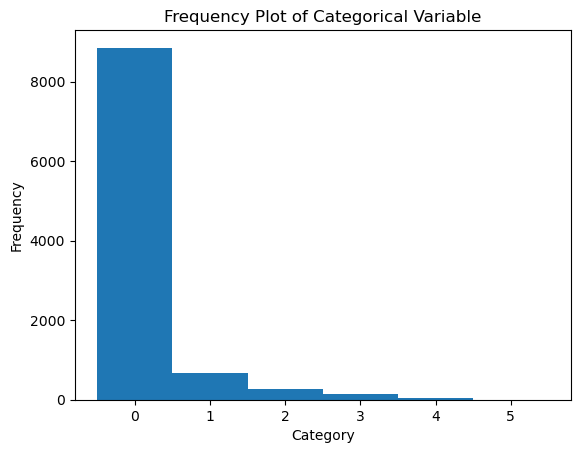

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the occurrences of each category
category_counts = df_total['Dog'].value_counts()

# Create a bar plot (histogram-like)
plt.bar(category_counts.index, category_counts.values, width=1)

# Add labels and title
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Frequency Plot of Categorical Variable')
plt.show()


## Trying it on the real data --> 75%

In [3]:
import pandas as pd

In [4]:
df_tot = pd.read_csv('sub_dataset.csv', dtype=dtype)

In [5]:
df_tot.shape

(5000000, 31)

## Hier encode je en haal je responseID weg voordat je gaat oversamplen, waarom????

##### ResponseID weghalen snap ik, want die hoef je niet te oversamplen

In [6]:
df_tot = pd.get_dummies(df_tot, columns=['AttributeLevel', 'ScenarioTypeStrict'])

In [7]:
# want 3.75M in the final dataset, so need to delete 4.9M - 3.75M = 1.15M rows of the 0 class
# use the subset function

def make_subset(data, sample_size, filter_value, types):
    df_tot = pd.read_csv(data, dtype=dtype)
    sample = int(sample_size/2)

    df_tot = df_tot[df_tot['UserID'] == filter_value]                                           # getting a subset of either only LLM's or MME's (1 or 0)
    unique_ids = df_tot.drop_duplicates(subset=['ResponseID'], keep='first')                    # only keeping unique ResponseID's (not their duplicate)
    RID_list = unique_ids['ResponseID'].sample(n=sample, random_state=41).to_list()             # to a list the ResponseID's to be kept

    print(len(RID_list)*2)  # expected size of output df


    new_df = pd.DataFrame()

    chunk_size = 500_000
    reader = pd.read_csv(data, chunksize=chunk_size, dtype=str, low_memory=False)

    for i, chunk in enumerate(reader):
    
        print(f"Processing chunk {i+1}")

        # Filter rows where ResponseID is in reader_subset
        subset_chunk = chunk[chunk['ResponseID'].isin(RID_list)]

        # Append filtered chunk to empty df
        new_df = pd.concat([new_df, subset_chunk], ignore_index=True)

        print(f"Finished processing chunk {i+1}")

    print("All chunks have been processed and combined.")

    print(new_df.shape)

    # check if all are unique
    print(new_df['ResponseID'].nunique())

    new_df = new_df.astype(dtype=types)
    
    return new_df

In [8]:
# making subset of 3.75M of class 0
df_sub_0 = make_subset('sub_dataset.csv', 3750000, 0, dtype)

3750000
Processing chunk 1
Finished processing chunk 1
Processing chunk 2
Finished processing chunk 2
Processing chunk 3
Finished processing chunk 3
Processing chunk 4
Finished processing chunk 4
Processing chunk 5
Finished processing chunk 5
Processing chunk 6
Finished processing chunk 6
Processing chunk 7
Finished processing chunk 7
Processing chunk 8
Finished processing chunk 8
Processing chunk 9
Finished processing chunk 9
Processing chunk 10
Finished processing chunk 10
All chunks have been processed and combined.
(3750000, 31)
1875000


In [9]:
# take the full LLM's from the total 14 million dataset
# cause that one is fully preprocessed, and reloading the llm dataset from scratch is not
# I want to take all instances of the LLM (293568), and use them for oversampling
# If i would take the LLM data from the 5M dataset, I would only get 100.000 instances

df_total_14M = pd.read_csv('total_dataset.csv', dtype=dtype)

In [10]:
# Only llm of the dataset

df_1 = df_total_14M[df_total_14M['UserID'] == 1]

In [11]:
df_1.shape

(293568, 31)

In [12]:
# adding this only LLM part to only the MME part of the df_tot dataset
# use this new dataset to oversample the minority class (llm's, 1)

df_tot = pd.concat([df_1, df_sub_0], ignore_index=True)


In [13]:
def create_total_subset(df1, df2, types):
    new_df = pd.concat([df1, df2], ignore_index=True)
    new_df = new_df.sample(frac=1, random_state=42).reset_index(drop=True)
    new_df = new_df.astype(dtype=types)
    return new_df

In [14]:
df_with_375_0 = create_total_subset(df_sub_0, df_1, dtype)

print(df_with_375_0.shape)
print(df_with_375_0['UserID'].value_counts())

(4043568, 31)
UserID
0    3750000
1     293568
Name: count, dtype: int64


...

In [15]:
# Now the actual oversampling
# want to oversample the minority class of 1, so that it has 1.250.000 instances (and the total dataset 5M)
# need to make 1.25M of 293568

In [16]:
# eerst weer one-hot encoding dus

df_with_375_0 = pd.get_dummies(df_with_375_0, columns=['AttributeLevel', 'ScenarioTypeStrict'])

In [17]:
X_375 = df_with_375_0.drop(['UserID', 'ResponseID'], axis=1)
y_375 = df_with_375_0['UserID']

In [18]:
X_375.shape

(4043568, 47)

In [19]:
y_375.value_counts()

UserID
0    3750000
1     293568
Name: count, dtype: int64

In [20]:
from imblearn.over_sampling import RandomOverSampler 

In [21]:
# Apply Random Oversampling
sampling_strategy = {0: 37500000, 1: 12500000}
random_oversampler = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

In [22]:
# bepalen of je eerst SMOTE of random oversampling gaat doen
# distributie van de data??

# doe ditzelfde voor de 50/50 dataset
# doe K-fold implementeren bij de modellen
# nog een keer MLP runnen

In [23]:
# Fit resampler
X_random, y_random = random_oversampler.fit_resample(X_375, y_375)

In [24]:
y_random.value_counts()

UserID
0    37500000
1    12500000
Name: count, dtype: int64

In [26]:
df_total_75 = pd.concat([X_random, y_random], axis=1)

In [34]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', '{:.4f}'.format)

df_tot[df_tot['UserID'] == 1].describe()

,UserID,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat
count,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000,293568.0000
mean,1.0000,0.5000,0.5099,0.2451,0.5662,3.0125,0.2940,0.5000,0.3174,0.3111,0.0777,0.0424,0.1666,0.1666,0.1709,0.1659,0.1001,0.1525,0.1586,0.1001,0.1121,0.1117,0.1585,0.1608,0.1120,0.1105,0.1571,0.1600
std,0.0000,0.5000,0.4999,0.4301,0.7876,1.4128,0.7550,0.5000,0.5861,0.5807,0.3052,0.2150,0.4888,0.4884,0.4948,0.4830,0.3767,0.4629,0.4753,0.3800,0.3668,0.3647,0.4723,0.4761,0.3660,0.3634,0.5504,0.5574
min,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1.0000,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,1.0000,0.5000,1.0000,0.0000,0.0000,3.0000,0.0000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
75%,1.0000,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
max,1.0000,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000


In [35]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.float_format', '{:.4f}'.format)

df_total_75[df_total_75['UserID'] == 1].describe()

,Intervention,PedPed,Barrier,CrossingSignal,NumberOfCharacters,DiffNumberOFCharacters,Saved,Man,Woman,Pregnant,Stroller,OldMan,OldWoman,Boy,Girl,Homeless,LargeWoman,LargeMan,Criminal,MaleExecutive,FemaleExecutive,FemaleAthlete,MaleAthlete,FemaleDoctor,MaleDoctor,Dog,Cat,UserID
count,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000,12500000.0000
mean,0.4998,0.5099,0.2450,0.5664,3.0127,0.2942,0.5002,0.3176,0.3110,0.0776,0.0424,0.1667,0.1667,0.1708,0.1660,0.1001,0.1526,0.1587,0.1000,0.1122,0.1117,0.1584,0.1608,0.1120,0.1106,0.1568,0.1600,1.0000
std,0.5000,0.4999,0.4301,0.7876,1.4128,0.7553,0.5000,0.5863,0.5806,0.3049,0.2147,0.4890,0.4886,0.4945,0.4831,0.3766,0.4632,0.4752,0.3799,0.3670,0.3648,0.4724,0.4764,0.3657,0.3634,0.5499,0.5574,0.0000
min,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
25%,0.0000,0.0000,0.0000,0.0000,2.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
50%,0.0000,1.0000,0.0000,0.0000,3.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,1.0000,1.0000,0.0000,1.0000,4.0000,0.0000,1.0000,1.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
max,1.0000,1.0000,1.0000,2.0000,5.0000,4.0000,1.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,5.0000,4.0000,5.0000,5.0000,4.0000,4.0000,5.0000,5.0000,1.0000


In [29]:
df_total_75.to_csv('sub_dataset_75.csv', index=False)

In [41]:
print(df_total_75.columns)
print(len(df_total_75.columns))

Index(['Intervention', 'PedPed', 'Barrier', 'CrossingSignal',
       'NumberOfCharacters', 'DiffNumberOFCharacters', 'Saved', 'Man', 'Woman',
       'Pregnant', 'Stroller', 'OldMan', 'OldWoman', 'Boy', 'Girl', 'Homeless',
       'LargeWoman', 'LargeMan', 'Criminal', 'MaleExecutive',
       'FemaleExecutive', 'FemaleAthlete', 'MaleAthlete', 'FemaleDoctor',
       'MaleDoctor', 'Dog', 'Cat', 'AttributeLevel_Fat',
       'AttributeLevel_Female', 'AttributeLevel_Fit', 'AttributeLevel_High',
       'AttributeLevel_Hoomans', 'AttributeLevel_Less', 'AttributeLevel_Low',
       'AttributeLevel_Male', 'AttributeLevel_More', 'AttributeLevel_Old',
       'AttributeLevel_Pets', 'AttributeLevel_Rand', 'AttributeLevel_Young',
       'ScenarioTypeStrict_Age', 'ScenarioTypeStrict_Fitness',
       'ScenarioTypeStrict_Gender', 'ScenarioTypeStrict_Social Status',
       'ScenarioTypeStrict_Social Value', 'ScenarioTypeStrict_Species',
       'ScenarioTypeStrict_Utilitarian', 'UserID'],
      dtype='object

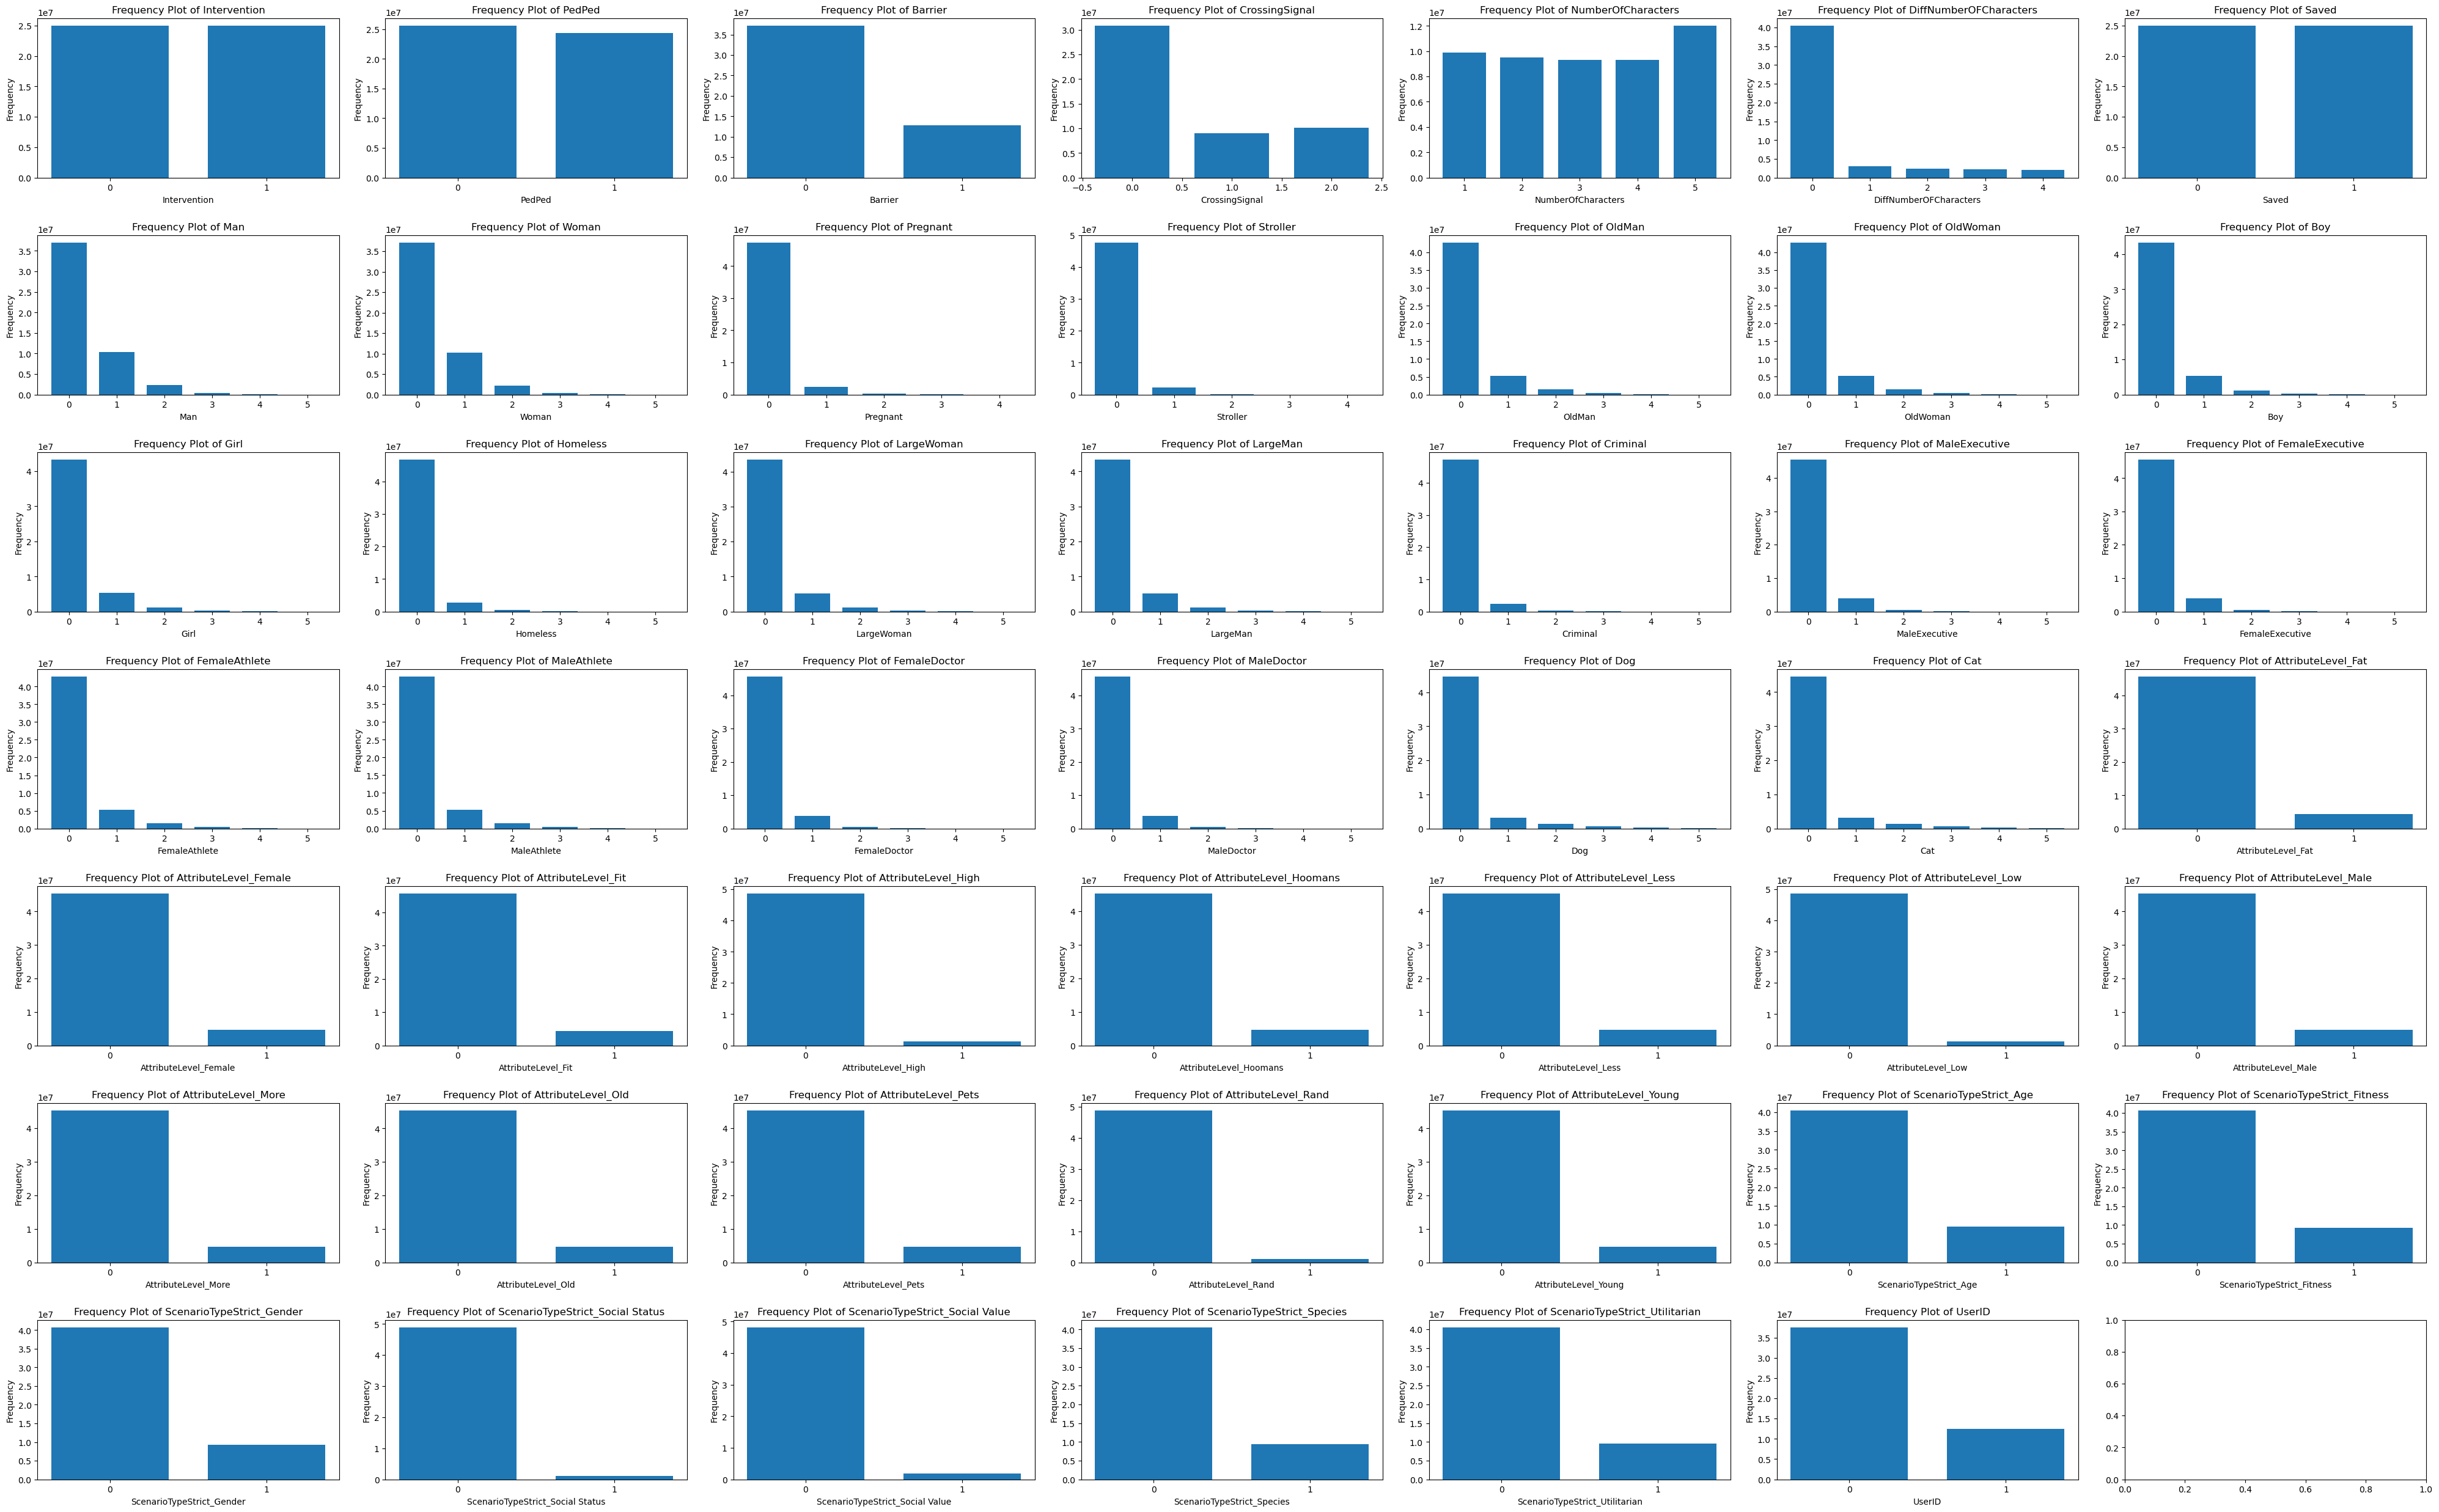

In [42]:
import pandas as pd
import matplotlib.pyplot as plt


# List of columns for which to plot the frequency plots
column_list = df_total_75.columns.tolist()

# Set up the figure and subplots (adjust the number of rows/columns depending on the number of plots)
fig, axes = plt.subplots(7, 7, figsize=(40, 25))  # 2 rows, 3 columns, adjust as needed
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through the columns and create subplots
for i, column in enumerate(column_list):
    # Count the occurrences of each category
    category_counts = df_total_75[column].value_counts()

    # Create a bar plot in the corresponding subplot axis
    axes[i].bar(category_counts.index, category_counts.values, width=0.75)

    # Add labels and title for each subplot
    axes[i].set_xlabel(str(column))
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f"Frequency Plot of {column}")

    # If the plot has only 2 categories, adjust the x-ticks to show 0 and 1
    if len(category_counts.index) == 2:
        axes[i].set_xticks([0, 1])

# Automatically adjust the layout for better spacing
plt.tight_layout()

# Show the entire figure with all subplots
plt.show()
